# Ground-roll attenuation model with attention

Raw field seismograms contain noises of various nature. One type of noise is assosiated with ground-roll waves propagation. The model should suppress the ground-roll noise and keep desired signal unchanged.

In [6]:
import os
import sys
import shutil
from functools import reduce
from pprint import pprint

import numpy as np
from matplotlib import pyplot as plt

sys.path.append('../../..')

from seismicpro.batchflow import Pipeline, V

from seismicpro.src import SeismicDataset, FieldIndex #,  merge_segy_files
from seismicpro.models import UnetAtt, FieldMetrics
from seismicpro.models.unetatt_3 import UnetAttention4, UnetAttention3

from metric_utils import get_windowed_spectrogram_dists

In [2]:
def get_pos(batch, *args):
    sx = batch.trace_headers('SourceX', flatten=True)[0]
    sy = batch.trace_headers('SourceY', flatten=True)[0]
    return sx, sy

def eval_mt(batch, *args):
    mt = FieldMetrics(batch.lift[0], batch.ml[0])
    return mt.mae(), mt.corr_coef()

def eval_dist(batch, *args):
    n_use_traces = 200
    dist_m = get_windowed_spectrogram_dists(batch.lift[0][0:n_use_traces], batch.ml[0][0:n_use_traces])
    dist = np.mean(dist_m)
    return dist
    

In [3]:
def _test(path_lift, model_out):
    m_index = (FieldIndex(name='ml', extra_headers=['SourceX', 'SourceY'], path=model_out)
               .merge(FieldIndex(name='lift', path=path_lift)))
    
    dset = SeismicDataset(m_index)
    
    metr_pipeline = (Pipeline()
                 .init_variable('mt', default=[])
                 .init_variable('pos', default=[])
                 .init_variable('dist', default=[])
                 .load(components=('ml', 'lift'), fmt='segy', tslice=np.arange(3000))
                 .call(get_pos, save_to=V('pos', mode='a'))
                 .call(eval_mt, save_to=V('mt', mode='a'))
                 .call(eval_dist, save_to=V('dist', mode='a')))
    
    metr_pipeline = metr_pipeline << dset
    metr_pipeline = metr_pipeline.run(batch_size=1, n_epochs=1, drop_last=False,
                                      shuffle=False, bar=True)
    
    pos = np.vstack(metr_pipeline.get_variable('pos'))
    mt = np.vstack(metr_pipeline.get_variable('mt'))
    dist = np.asarray(metr_pipeline.get_variable('dist'))
    
    return pos, mt, dist

def draw_xy(pos, var, desc, ax):
    sc = ax.scatter(*pos.T, c=var)
    plt.colorbar(sc, ax=ax)
    ax.set_title('{} = {:.4}'.format(desc, np.mean(var)))
    ax.set_xlabel('SourceX')
    ax.set_ylabel('SourceY')

def draw_metrics(pos, mt, dist):
    fig, ax = plt.subplots(1, 3, figsize=(20, 5))
    draw_xy(pos, dist, "DIST", ax[0])
    draw_xy(pos, mt[:, 0], "MAE", ax[1])
    draw_xy(pos, mt[:, 1], "Averaged trace correlation", ax[2])
    
def do_test(train_DS, model, path, test_DS, draw=True):
    path_lift = lifts[test_DS]
    path_out = os.path.join(path, test_DS + '_out.sgy')
    pos, mt, dist = _test(path_lift, path_out)
    if draw:
        print("{model} trained on {train_ds} tested on {test_ds}".format(
            model=model, train_ds=train_DS, test_ds=test_DS))
        draw_metrics(pos, mt, dist)
    return model, train_DS, test_DS, np.mean(mt[:, 0]), np.mean(mt[:, 1]), np.mean(dist)

In [7]:
inputs = []

inp_d = {
    'noise_dataset_1': {
        'UnetAttention3': "./saved_models/noise_dataset_1/UnetAttention3/2019-10-08_13:01:12.296337+03:00",
        'UnetAttention4': "./saved_models/noise_dataset_1/UnetAttention4/2019-10-08_13:27:57.070603+03:00",
        'UnetAtt': "./saved_models/noise_dataset_1/UnetAtt/2019-10-08_13:15:31.021212+03:00"
    },
 'YL1_UKM': {
     'UnetAttention3': "./saved_models/YL1_UKM/UnetAttention3/2019-10-08_19:22:03.834257+03:00",
     'UnetAttention4': "./saved_models/YL1_UKM/UnetAttention4/2019-10-08_17:51:27.015153+03:00",
     'UnetAtt': "./saved_models/YL1_UKM/UnetAtt/2019-10-08_17:29:10.283045+03:00",
 }
}

lifts = {
   'noise_dataset_1': '/notebooks/data/noise_dataset_1/DN02B_SHOTS_LIFT1_norm2.sgy',
    'YL1_UKM': '/notebooks/data/YL1_UKM/03_NA-gr_output_lift2_agora_norm2.sgy'
}

for ds_train in inp_d:
    for model, path in inp_d[ds_train].items():
        for test_ds in lifts:
            inputs.append(dict(train_DS=ds_train, model=model, path=path, test_DS=test_ds))
            

pprint(inputs)

save_res=[]

[{'model': 'UnetAtt',
  'path': './saved_models/noise_dataset_1/UnetAtt/2019-10-08_13:15:31.021212+03:00',
  'test_DS': 'noise_dataset_1',
  'train_DS': 'noise_dataset_1'},
 {'model': 'UnetAtt',
  'path': './saved_models/noise_dataset_1/UnetAtt/2019-10-08_13:15:31.021212+03:00',
  'test_DS': 'YL1_UKM',
  'train_DS': 'noise_dataset_1'},
 {'model': 'UnetAttention3',
  'path': './saved_models/noise_dataset_1/UnetAttention3/2019-10-08_13:01:12.296337+03:00',
  'test_DS': 'noise_dataset_1',
  'train_DS': 'noise_dataset_1'},
 {'model': 'UnetAttention3',
  'path': './saved_models/noise_dataset_1/UnetAttention3/2019-10-08_13:01:12.296337+03:00',
  'test_DS': 'YL1_UKM',
  'train_DS': 'noise_dataset_1'},
 {'model': 'UnetAttention4',
  'path': './saved_models/noise_dataset_1/UnetAttention4/2019-10-08_13:27:57.070603+03:00',
  'test_DS': 'noise_dataset_1',
  'train_DS': 'noise_dataset_1'},
 {'model': 'UnetAttention4',
  'path': './saved_models/noise_dataset_1/UnetAttention4/2019-10-08_13:27:57.070

In [8]:
len(inputs)

12

100%|██████████| 48/48 [01:20<00:00,  1.62s/it]


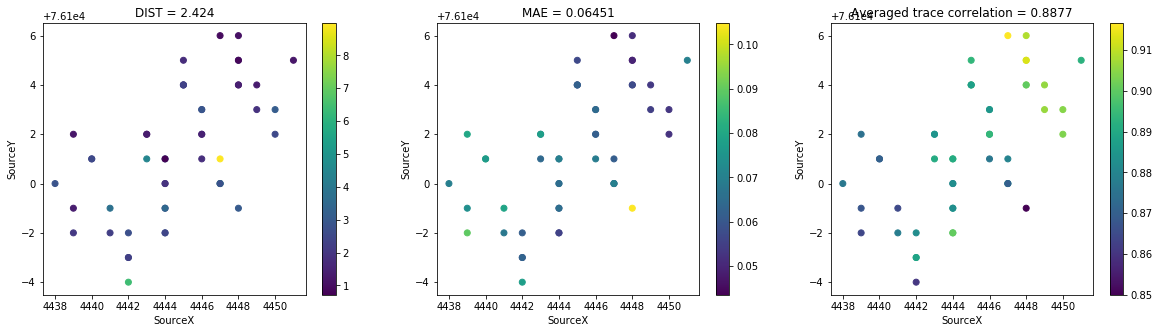

In [7]:
path_lift = '/notebooks/data/YL1_UKM/03_NA-gr_output_lift2_agora_norm2.sgy'
path_lift1 = '/notebooks/data/YL1_UKM/02_NA-gr_output_lift1_fdnat_norm2.sgy'

pos, mt, dist = _test(path_lift, path_lift1)
draw_metrics(pos, mt, dist)

100%|██████████| 51/51 [00:56<00:00,  1.11s/it]


UnetAtt trained on noise_dataset_1 tested on noise_dataset_1


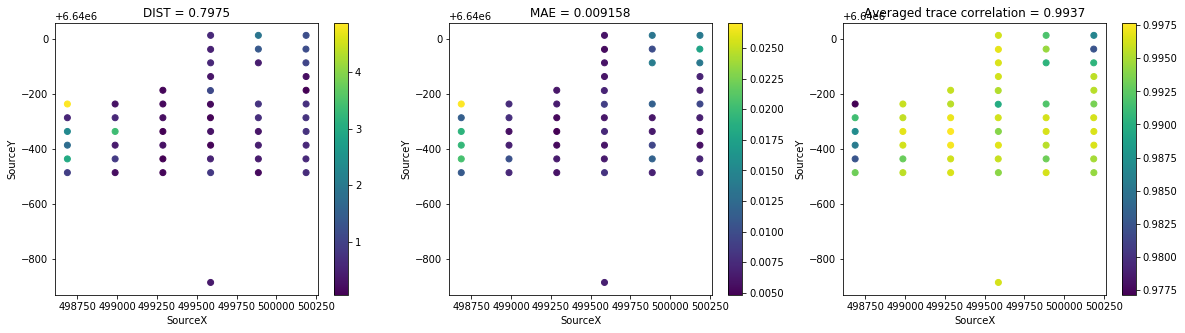

In [9]:
i = 0
save_res.append(do_test(**inputs[i]))

100%|██████████| 48/48 [01:26<00:00,  1.81s/it]


UnetAtt trained on noise_dataset_1 tested on YL1_UKM


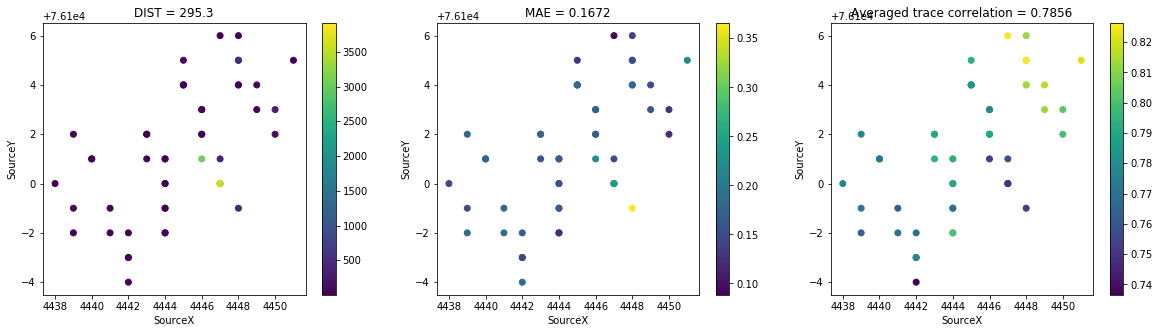

In [10]:
i = 1
save_res.append(do_test(**inputs[i]))

100%|██████████| 51/51 [00:56<00:00,  1.10s/it]


UnetAttention3 trained on noise_dataset_1 tested on noise_dataset_1


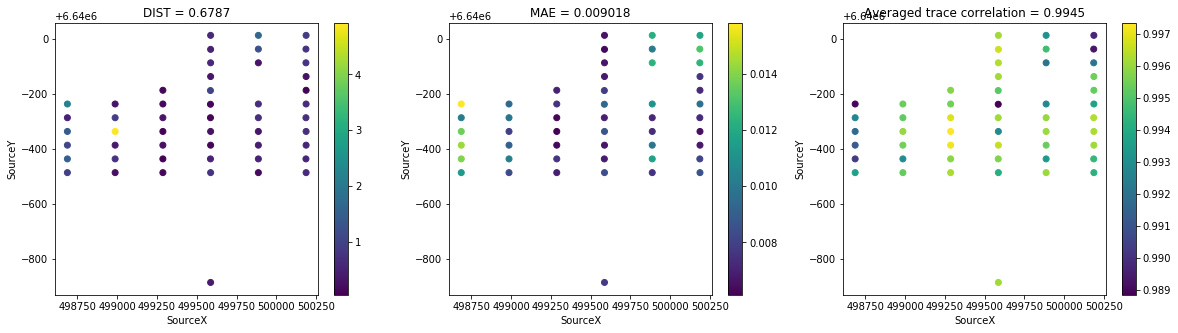

In [11]:
i = 2
save_res.append(do_test(**inputs[i]))

100%|██████████| 48/48 [01:25<00:00,  1.74s/it]


UnetAttention3 trained on noise_dataset_1 tested on YL1_UKM


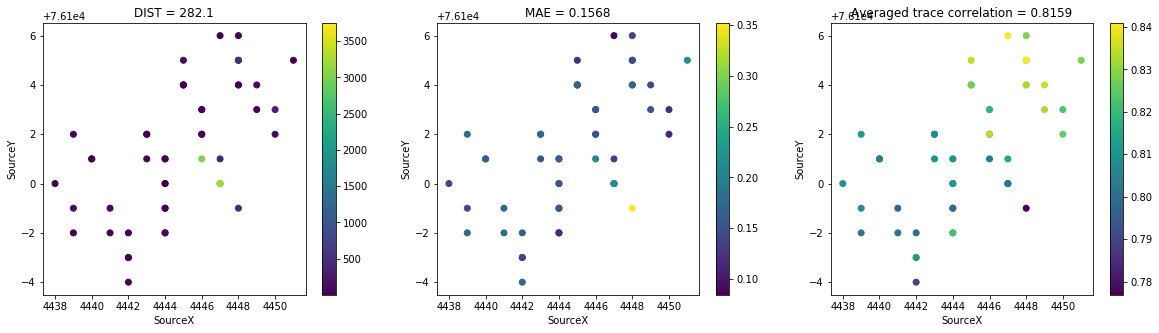

In [12]:
i = 3
save_res.append(do_test(**inputs[i]))

100%|██████████| 51/51 [00:57<00:00,  1.13s/it]


UnetAttention4 trained on noise_dataset_1 tested on noise_dataset_1


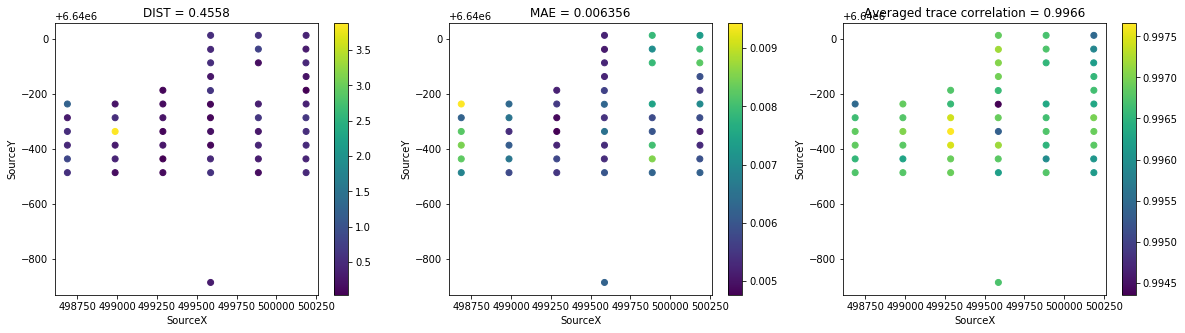

In [13]:
i = 4
save_res.append(do_test(**inputs[i]))

100%|██████████| 48/48 [01:23<00:00,  1.77s/it]


UnetAttention4 trained on noise_dataset_1 tested on YL1_UKM


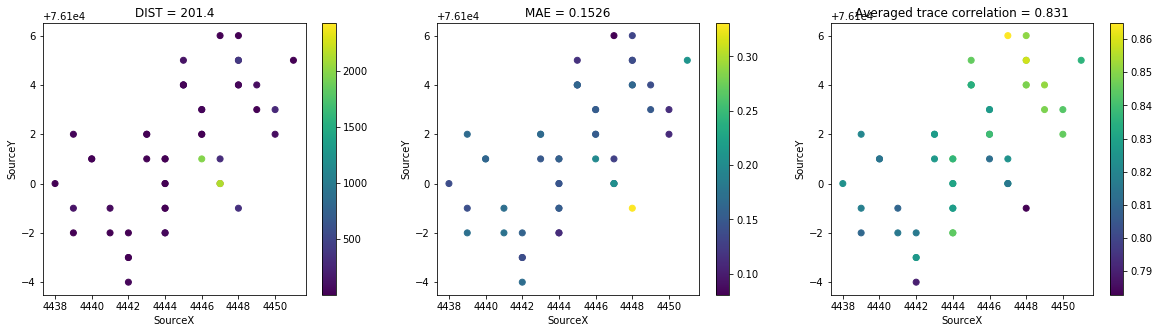

In [14]:
i = 5
save_res.append(do_test(**inputs[i]))

100%|██████████| 51/51 [00:56<00:00,  1.11s/it]


UnetAtt trained on YL1_UKM tested on noise_dataset_1


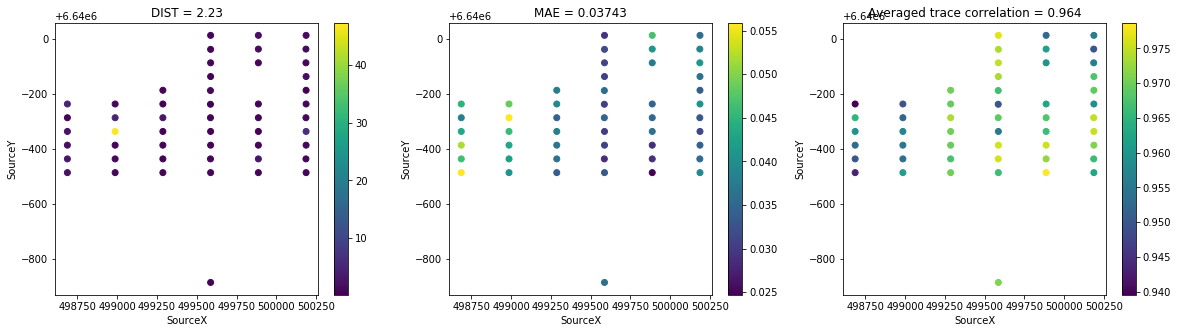

In [15]:
i = 6
save_res.append(do_test(**inputs[i]))

100%|██████████| 48/48 [01:25<00:00,  1.77s/it]


UnetAtt trained on YL1_UKM tested on YL1_UKM


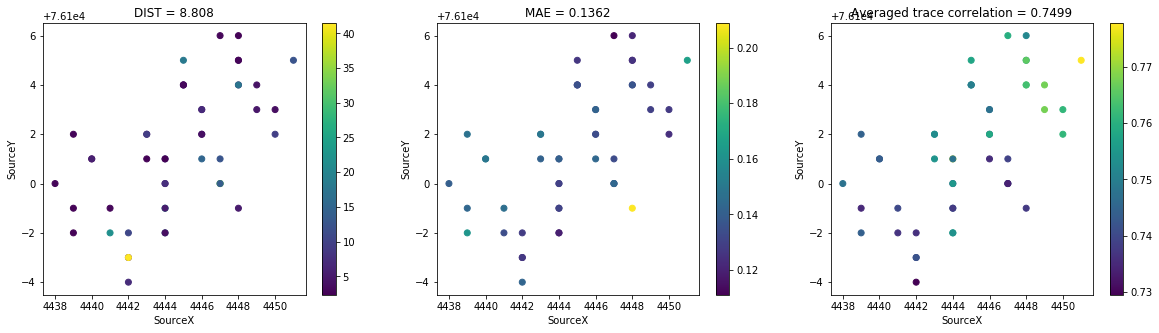

In [16]:
i = 7
save_res.append(do_test(**inputs[i]))

100%|██████████| 51/51 [01:02<00:00,  1.29s/it]


UnetAttention3 trained on YL1_UKM tested on noise_dataset_1


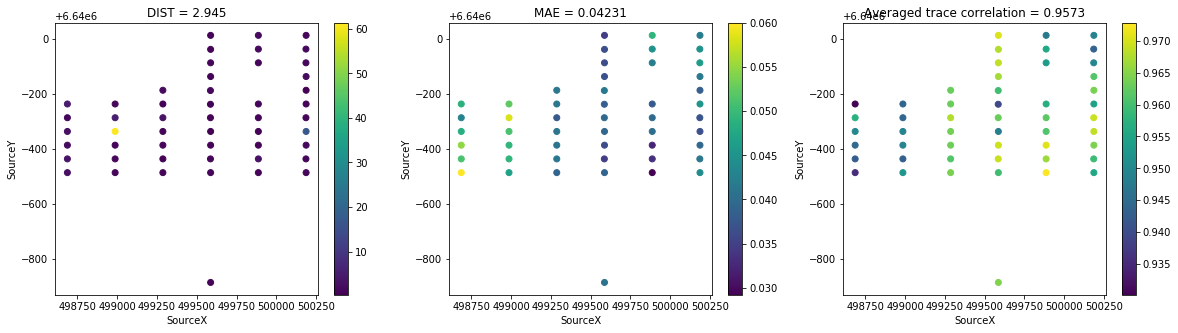

In [17]:
i = 8
save_res.append(do_test(**inputs[i]))

100%|██████████| 48/48 [01:25<00:00,  1.78s/it]


UnetAttention3 trained on YL1_UKM tested on YL1_UKM


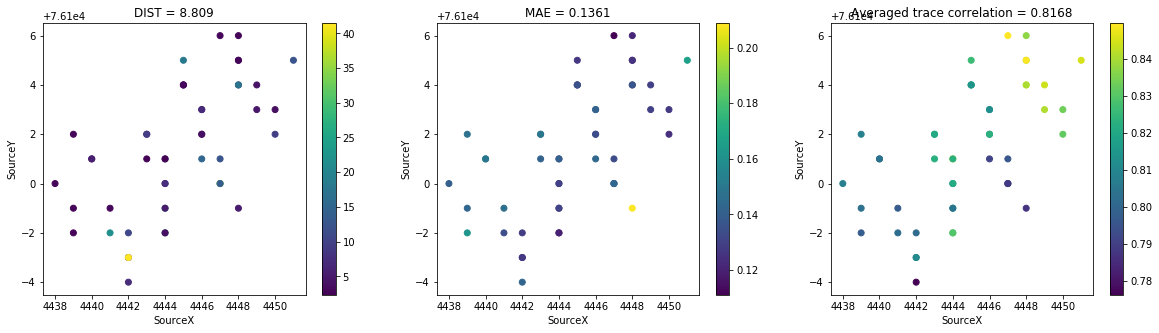

In [18]:
i = 9
save_res.append(do_test(**inputs[i]))

100%|██████████| 51/51 [01:07<00:00,  1.44s/it]


UnetAttention4 trained on YL1_UKM tested on noise_dataset_1


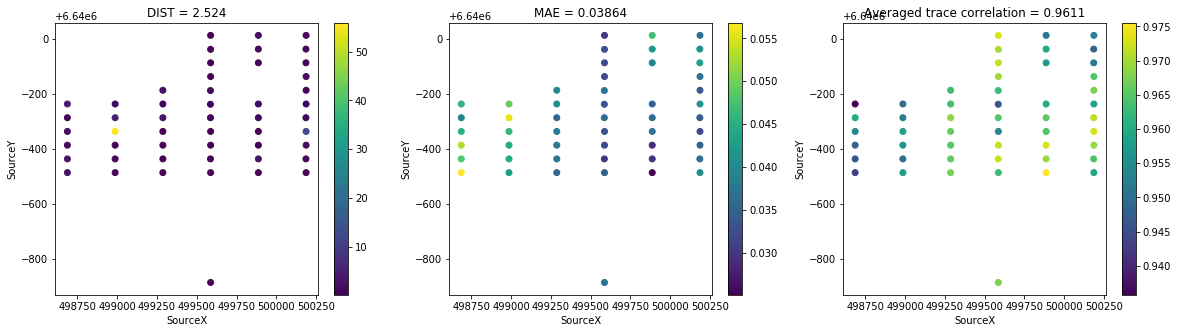

In [19]:
i = 10
save_res.append(do_test(**inputs[i]))

100%|██████████| 48/48 [01:24<00:00,  1.71s/it]


UnetAttention4 trained on YL1_UKM tested on YL1_UKM


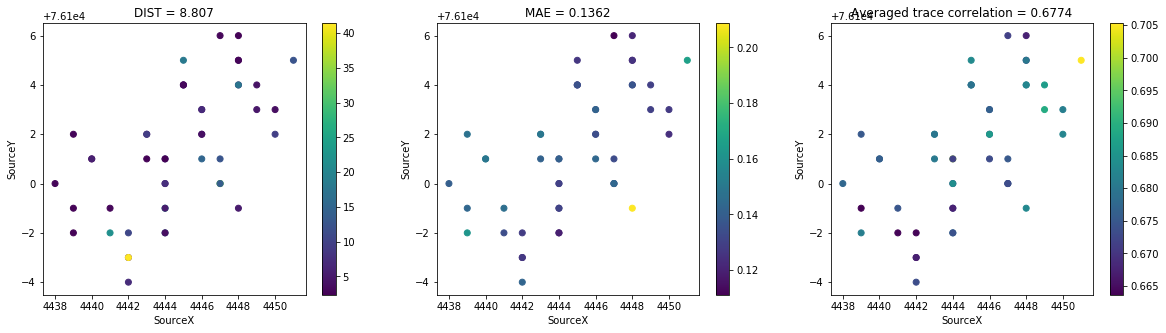

In [20]:
i = 11
save_res.append(do_test(**inputs[i]))

In [22]:
import pandas as pd

res = pd.DataFrame.from_records(save_res, columns=['Model', 'DS_train', 'DS_test', 'MAE', 'Corr', 'Dist'])
res

,Model,DS_train,DS_test,MAE,Corr,Dist
0,UnetAtt,noise_dataset_1,noise_dataset_1,0.009158,0.993716,0.797507
1,UnetAtt,noise_dataset_1,YL1_UKM,0.167228,0.785584,295.298065
2,UnetAttention3,noise_dataset_1,noise_dataset_1,0.009018,0.994473,0.678747
3,UnetAttention3,noise_dataset_1,YL1_UKM,0.156774,0.815853,282.070923
4,UnetAttention4,noise_dataset_1,noise_dataset_1,0.006356,0.996598,0.455847
5,UnetAttention4,noise_dataset_1,YL1_UKM,0.152560,0.831037,201.420166
6,UnetAtt,YL1_UKM,noise_dataset_1,0.037435,0.964012,2.230063
7,UnetAtt,YL1_UKM,YL1_UKM,0.136183,0.749906,8.808386
8,UnetAttention3,YL1_UKM,noise_dataset_1,0.042311,0.957306,2.944710
9,UnetAttention3,YL1_UKM,YL1_UKM,0.136141,0.816789,8.809277
